In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声, 都是正态分布的噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))  #代码规范：-1是一个占位符让pytorch自己计算应当是多少，确保生成的是一个列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 10000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.6333, -1.0503]) 
label: tensor([4.4949])


'1.变成numpy数组是必须的，因为matplotlib并不直接接受pytorch张量\n2.'

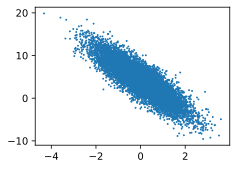

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);
''' 我们无法直接可视化一个二维特征 (x1, x2) 和 y 构成的三维空间。为了方便，我们只取其中一维特征（这里是索引为1的特征，也就是 x_2）和标签 y 来画一个二维散点图。'''

'''1.变成numpy数组是必须的，因为matplotlib并不直接接受pytorch张量
2.'''

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))#0-999的索引列表
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)#随机打乱列表，使学习过程更平稳
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
'''yield: 这是 Python 中 generator（生成器）的关键字。它和 return 很像，但 yield 在返回一个值后会“暂停”函数的执行，下次再调用它时会从“暂停”的地方继续。这使得 data_iter 函数非常节省内存。它不是一次性把所有的小批次都创建好放在内存里，而是在 for 循环需要的时候，才实时地生成下一个批次。

features[batch_indices]: 这利用了 PyTorch 的高级索引功能。我们用一个索引张量 batch_indices，从 features 中一次性地、不连续地取出所有对应索引的行，组成一个新的张量。labels同理'''

'yield: 这是 Python 中 generator（生成器）的关键字。它和 return 很像，但 yield 在返回一个值后会“暂停”函数的执行，下次再调用它时会从“暂停”的地方继续。这使得 data_iter 函数非常节省内存。它不是一次性把所有的小批次都创建好放在内存里，而是在 for 循环需要的时候，才实时地生成下一个批次。\n\nfeatures[batch_indices]: 这利用了 PyTorch 的高级索引功能。我们用一个索引张量 batch_indices，从 features 中一次性地、不连续地取出所有对应索引的行，组成一个新的张量。labels同理'

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6490,  0.2826],
        [ 0.4445,  0.3211],
        [-0.1627, -1.9642],
        [-0.4359,  1.0887],
        [-0.3366, -0.8156],
        [-1.3137, -0.9819],
        [ 0.3598,  0.3680],
        [ 0.2289,  2.3584],
        [ 0.0696,  0.0746],
        [ 0.7480, -0.0531]]) 
 tensor([[ 1.9396],
        [ 3.9898],
        [10.5722],
        [-0.3574],
        [ 6.2824],
        [ 4.9153],
        [ 3.6794],
        [-3.3669],
        [ 4.0961],
        [ 5.8876]])


In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [7]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w)+ b

In [8]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [9]:
def sgd(params, lr , batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad /batch_size
            param.grad.zero_()#函数名后的下划线 _ 表示这是一个“原地（in-place）”操作。
            '''千万不要忘记下划线
            with torch.no_grad():: 这是一个非常重要的上下文管理器。它告诉PyTorch：“在这个代码块里，不要追踪任何操作，因为我正在手动更新参数，这个更新动作本身不属于需要求导的计算图的一部分。” 如果没有这句，更新操作本身也会被追踪，导致计算图异常复杂和错误。
            '''


In [10]:
lr = 0.001
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 2.252045
epoch 2, loss 0.308089
epoch 3, loss 0.042201
epoch 4, loss 0.005818
epoch 5, loss 0.000838
epoch 6, loss 0.000157
epoch 7, loss 0.000064
epoch 8, loss 0.000051
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-2.9564e-05, -1.4424e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)
